%pip install scipy

%pip install matplotlib

In [104]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

from scipy.stats import truncnorm
from scipy.stats import chi2_contingency
import scipy.stats as stats


# 1. Selección de Dataset Original

Seleccionen un dataset de Kaggle con las siguientes características:
- Contiene variables categóricas y numéricas.
- Es posible simular la expansión de registros usando las probabilidades de 
ocurrencia de las categorías.
- Asegúrense de elegir un dataset con al menos 500 registros.

## Leer dataset

In [105]:
df = pd.read_csv("Depression Student Dataset.csv")

## Analizar los tipos de datos

In [106]:
df.columns = df.columns.str.lower()

In [107]:
df.dtypes

gender                                    object
age                                        int64
academic pressure                        float64
study satisfaction                       float64
sleep duration                            object
dietary habits                            object
have you ever had suicidal thoughts ?     object
study hours                                int64
financial stress                           int64
family history of mental illness          object
depression                                object
dtype: object

## Renombrando las columnas

In [108]:
df.columns = ['gender','age','academic_pressure','study_satisfaction','sleep_duration','dietary_habits','suicidal_thoughts','study_hours','financial_stress','family_history','depression' ]

## Agregando ID a los usuarios

In [109]:
df['individual'] = range(1, len(df) + 1)


# 2. Análisis Exploratorio de Datos (EDA)
 Realicen un EDA completo en el dataset original, incluyendo:
 - Estadísticas descriptivas para las variables numéricas.
 - Distribuciones de las categorías principales.
 - Visualización de correlaciones entre variables.
 

Con base en los resultados de este análisis, seleccionen las variables categóricas 
que utilizarán en el paso de simulación. No es necesario usar todas las variables 
categóricas; elijan las que sean más relevantes.

## Estadisticas descriptivas para las variables numéricas

In [110]:
num_cols = []

for c in df.columns:
    if (df[c].dtype == 'int64' or df[c].dtype =='float64'):    
        num_cols.append(c)

num_cols

['age',
 'academic_pressure',
 'study_satisfaction',
 'study_hours',
 'financial_stress',
 'individual']

In [111]:
num_cols_df = pd.DataFrame(df[num_cols])
num_cols_df.head(2)

,age,academic_pressure,study_satisfaction,study_hours,financial_stress,individual
0,28,2.0,4.0,9,2,1
1,28,4.0,5.0,7,1,2


In [112]:
num_cols_df.describe()

,age,academic_pressure,study_satisfaction,study_hours,financial_stress,individual
count,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000
mean,26.241036,3.003984,3.075697,6.404382,2.928287,251.500000
std,4.896501,1.390007,1.373490,3.742434,1.425053,145.059183
min,18.000000,1.000000,1.000000,0.000000,1.000000,1.000000
25%,22.000000,2.000000,2.000000,3.000000,2.000000,126.250000
50%,26.500000,3.000000,3.000000,7.000000,3.000000,251.500000
75%,30.000000,4.000000,4.000000,10.000000,4.000000,376.750000
max,34.000000,5.000000,5.000000,12.000000,5.000000,502.000000


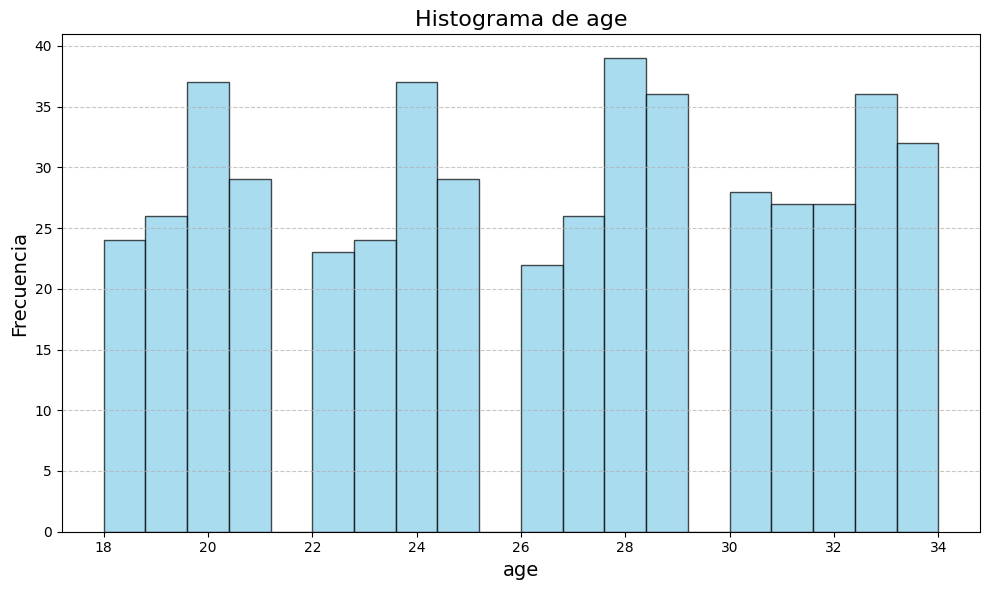

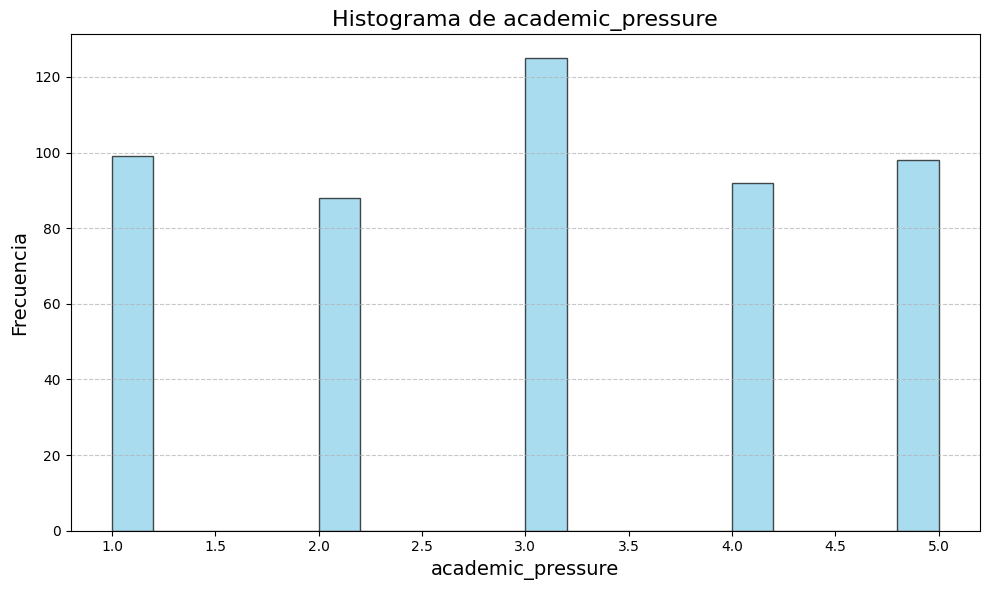

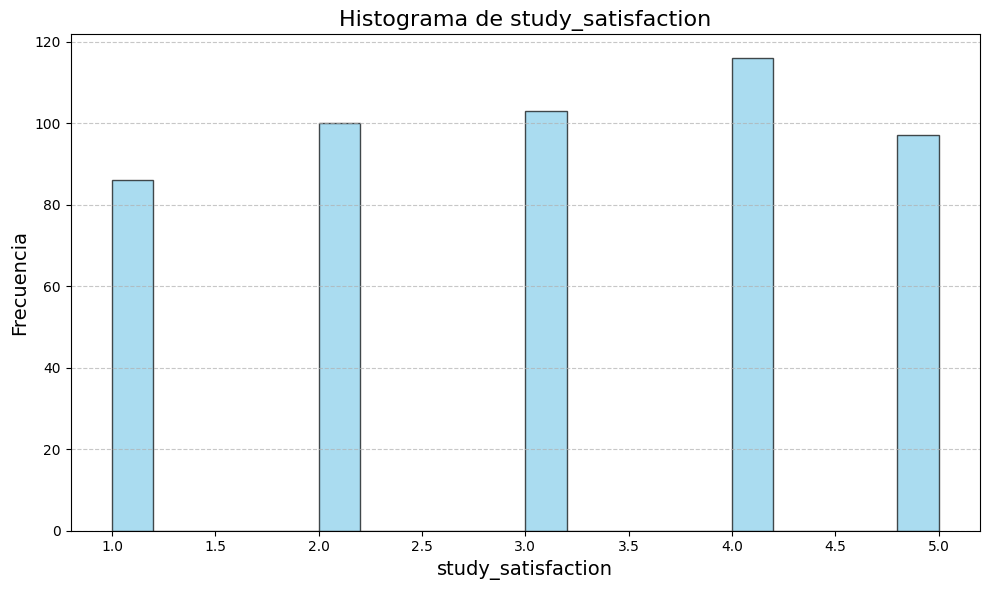

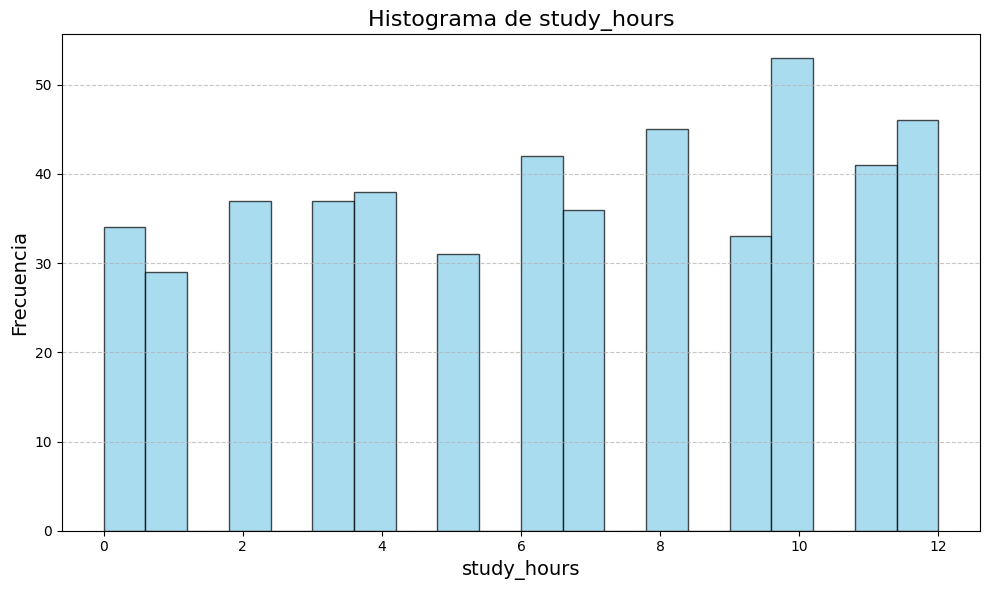

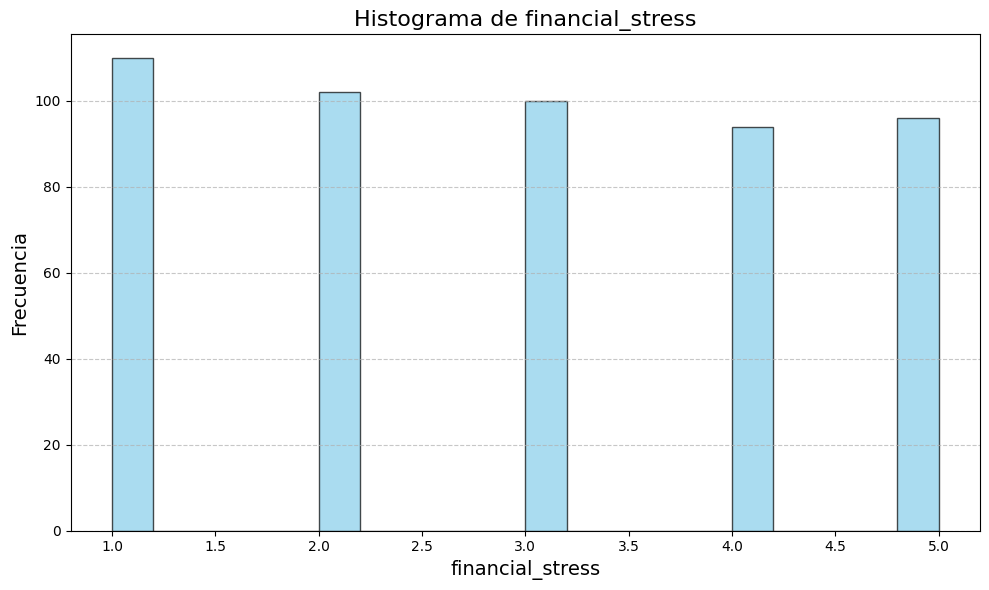

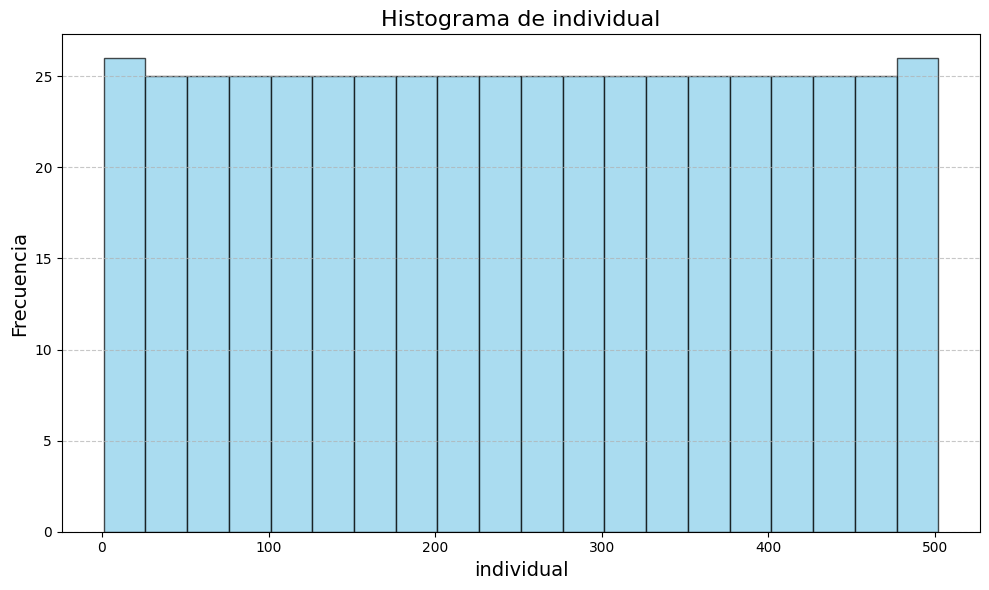

In [ ]:
for num_col in num_cols_df.columns:
    plt.figure(figsize=(10, 6))
    plt.hist(df[num_col], bins=20, color='skyblue', edgecolor='black', alpha=0.7)

    plt.title(f'Histograma de {num_col}', fontsize=16)
    plt.xlabel(f'{num_col}', fontsize=14)
    plt.ylabel('Frecuencia', fontsize=14)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()


## Distribuciones de las categorías principales

In [114]:
cat_cols = []

for c in df.columns:
    if df[c].dtype == 'object':
        cat_cols.append(c)

cat_cols

['gender',
 'sleep_duration',
 'dietary_habits',
 'suicidal_thoughts',
 'family_history',
 'depression']

## Visualización de correlación entre variables

Dado que nuestro target es la depresión en los estudiantes, aplicamos la prueba Chi Cuadrado a esta variable para saber cuáles son las variables categóricas más influyentes.

In [115]:
chi2_results = {}
for col in cat_cols:
    contingency = pd.crosstab(df[col], df['depression'])
    chi2, p, dof, expected = chi2_contingency(contingency)
    chi2_results[col] = {'chi2': chi2, 'p_value': p}

chi2_df = pd.DataFrame(chi2_results)
chi2_df

,gender,sleep_duration,dietary_habits,suicidal_thoughts,family_history,depression
chi2,0.384930,2.211071,18.069215,1.072925e+02,1.362454,4.980079e+02
p_value,0.534977,0.529771,0.000119,3.840861e-25,0.243113,2.578765e-110


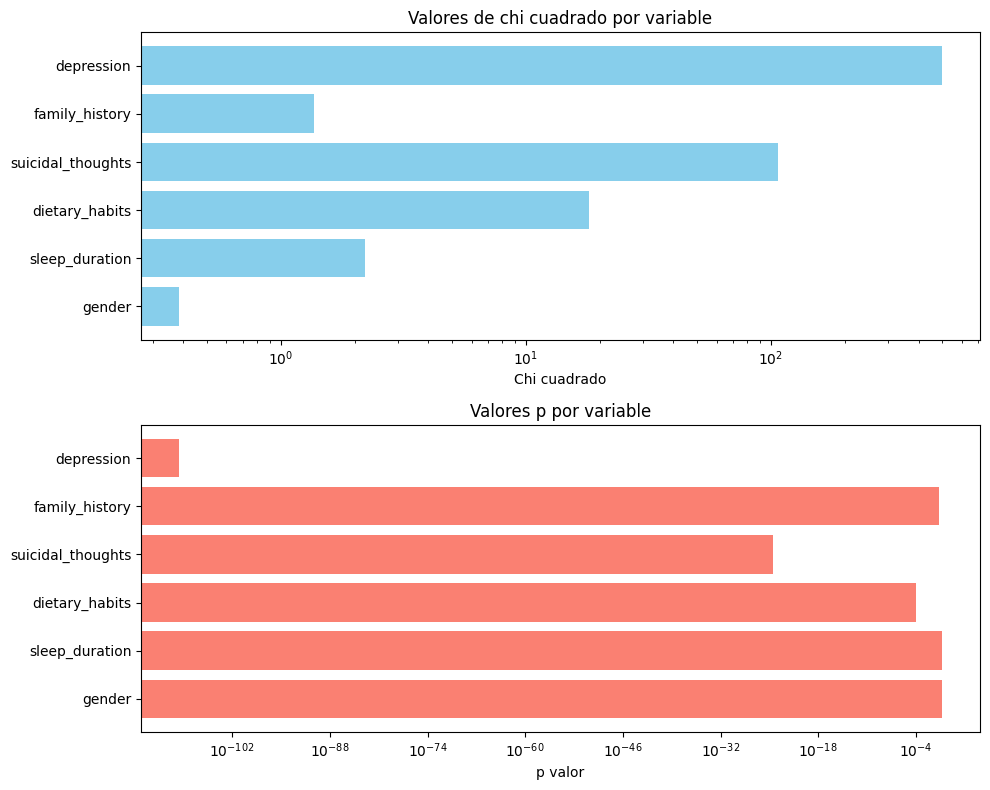

In [116]:
variables = [x[0] for x in chi2_results.items()]
p_values = [x[1]['p_value'] for x in chi2_results.items()]
chi2_values = [x[1]['chi2'] for x in chi2_results.items()]

fig, ax = plt.subplots(2, 1, figsize=(10, 8))

ax[0].barh(variables, chi2_values, color='skyblue')
ax[0].set_title('Valores de chi cuadrado por variable')
ax[0].set_xlabel('Chi cuadrado')
ax[0].set_xscale('log')

ax[1].barh(variables, p_values, color='salmon')
ax[1].set_title('Valores p por variable')
ax[1].set_xlabel('p valor')
ax[1].set_xscale('log')

plt.tight_layout()
plt.show()

Eliminamos las variables categóricas menos importantes para nuestro estudio:

In [117]:
cat_cols.remove('gender')
cat_cols.remove('sleep_duration')
cat_cols

['dietary_habits', 'suicidal_thoughts', 'family_history', 'depression']

## Agrupaciones para obtener las distribuciones probabilísticas de las categorías principales

In [118]:
prob_freq = df.groupby(cat_cols, as_index = False).agg({
    "individual" : ["count"]
})

prob_freq.columns = cat_cols + ['individuals']
prob_freq['individuals'] = prob_freq['individuals'] / df.shape[0]
prob_freq

,dietary_habits,suicidal_thoughts,family_history,depression,individuals
0,Healthy,No,No,No,0.069721
1,Healthy,No,No,Yes,0.011952
2,Healthy,No,Yes,No,0.067729
3,Healthy,No,Yes,Yes,0.015936
4,Healthy,Yes,No,No,0.033865
5,Healthy,Yes,No,Yes,0.041833
6,Healthy,Yes,Yes,No,0.021912
7,Healthy,Yes,Yes,Yes,0.057769
8,Moderate,No,No,No,0.069721
9,Moderate,No,No,Yes,0.021912


# 3. Simulación del Dataset Expandido
Usen las técnicas de expansión de datos presentadas en el notebook para 
generar un nuevo dataset con al menos 100,000 registros.
 
En el proceso, consideren:
- Calcular la probabilidad de ocurrencia de cada categoría y usar estas 
probabilidades para la expansión.
- Generar valores numéricos basados en la distribución de los valores originales 
y ajustar la distribución con la eliminación de valores atípicos.
- Eliminen los valores atípicos en las variables numéricas de acuerdo con las 
categorías seleccionadas para asegurar que los datos simulados mantengan 
una distribución realista.

## Eliminar valores atípicos

In [120]:
transformations = {}
new_cols = []

for c in num_cols:
    transformations[c] = [('lower_bound', lambda x: x.quantile(0.25) - 1.5*(x.quantile(0.75) - x.quantile(0.25)) ),
                          ('upper_bound', lambda x: x.quantile(0.75) + 1.5*(x.quantile(0.75) - x.quantile(0.25)) )
                        ]
    new_cols.append(f'{c}_lower_bound')
    new_cols.append(f'{c}_upper_bound')

In [121]:
df_results = df.groupby(cat_cols, as_index = False ).agg(transformations)

In [122]:
df_results.columns = cat_cols + new_cols

In [123]:
df_results.head(2)

,dietary_habits,suicidal_thoughts,family_history,depression,age_lower_bound,age_upper_bound,academic_pressure_lower_bound,academic_pressure_upper_bound,study_satisfaction_lower_bound,study_satisfaction_upper_bound,study_hours_lower_bound,study_hours_upper_bound,financial_stress_lower_bound,financial_stress_upper_bound,individual_lower_bound,individual_upper_bound
0,Healthy,No,No,No,13.5,41.5,-1.000,7.000,-1.000,7.000,-6.000,18.000,0.500,4.500,-286.75,727.25
1,Healthy,No,No,Yes,21.5,25.5,3.125,6.125,-0.125,2.875,5.375,12.375,0.625,7.625,-93.25,408.75


In [124]:
df_bound = df.merge(
    df_results,
    on = cat_cols,
    how = 'inner'
)
df_bound.head(2)

,gender,age,academic_pressure,study_satisfaction,sleep_duration,dietary_habits,suicidal_thoughts,study_hours,financial_stress,family_history,...,academic_pressure_lower_bound,academic_pressure_upper_bound,study_satisfaction_lower_bound,study_satisfaction_upper_bound,study_hours_lower_bound,study_hours_upper_bound,financial_stress_lower_bound,financial_stress_upper_bound,individual_lower_bound,individual_upper_bound
0,Male,28,2.0,4.0,7-8 hours,Moderate,Yes,9,2,Yes,...,0.5,4.5,2.50,6.50,-4.5,7.5,-0.50,3.50,-199.0,417.0
1,Male,28,4.0,5.0,5-6 hours,Healthy,Yes,7,1,Yes,...,-2.0,6.0,1.25,7.25,-2.5,13.5,-2.75,7.25,-359.5,824.5


In [125]:
for c in num_cols:
    print(f'Row: {df_bound.shape[0]}')
    print(f' {c}: processing...')

    df_bound = df_bound.loc[
        (df_bound[c] > df_bound[f'{c}_lower_bound'])
        &
        (df_bound[c] < df_bound[f'{c}_upper_bound'])
        , :
    ]
print('Completed!')

Row: 502
 age: processing...
Row: 496
 academic_pressure: processing...
Row: 487
 study_satisfaction: processing...
Row: 480
 study_hours: processing...
Row: 476
 financial_stress: processing...
Row: 468
 individual: processing...
Completed!


In [126]:
df_clean = df_bound.loc[:, cat_cols + num_cols]
df_clean.head(2)

,dietary_habits,suicidal_thoughts,family_history,depression,age,academic_pressure,study_satisfaction,study_hours,financial_stress,individual
1,Healthy,Yes,Yes,No,28,4.0,5.0,7,1,2
2,Unhealthy,Yes,No,Yes,25,1.0,3.0,10,4,3


## Resumen para la simulación

In [127]:
sum_aggregations = {}
cols_sums = []
for c in num_cols:
    sum_aggregations[c] = ['min', 'max','mean', 'std']
    cols_sums.append(f'{c}_min')
    cols_sums.append(f'{c}_max')
    cols_sums.append(f'{c}_mean')
    cols_sums.append(f'{c}_std')

In [128]:
df_sums = df_clean.groupby(
    cat_cols
    , as_index = False
).agg(sum_aggregations)

In [129]:
df_sums.columns = cat_cols + cols_sums

In [130]:
df_sums.head(2)

,dietary_habits,suicidal_thoughts,family_history,depression,age_min,age_max,age_mean,age_std,academic_pressure_min,academic_pressure_max,...,study_hours_mean,study_hours_std,financial_stress_min,financial_stress_max,financial_stress_mean,financial_stress_std,individual_min,individual_max,individual_mean,individual_std
0,Healthy,No,No,No,18,34,27.419355,4.759371,1.0,5.0,...,5.645161,3.610618,1,4,2.258065,0.964978,31,490,228.870968,140.045883
1,Healthy,No,No,Yes,23,24,23.333333,0.577350,4.0,5.0,...,9.333333,2.309401,3,5,4.000000,1.000000,93,216,136.666667,68.821024


## Expansión de DF final

In [131]:
ids = np.random.choice(prob_freq.index , size = 100000, p = prob_freq['individuals'].to_list())

In [ ]:
std_columns = [col for col in df_sums.columns if col.endswith('_std')]
rows_with_zero = df_sums[df_sums[std_columns] == 0].dropna(how='all').index
rows_with_zero.tolist()

prob_freq = prob_freq.drop(rows_with_zero)
df_sums = df_sums[~(df_sums[std_columns] == 0).any(axis=1)]

df_sums

,dietary_habits,suicidal_thoughts,family_history,depression,age_min,age_max,age_mean,age_std,academic_pressure_min,academic_pressure_max,...,study_hours_mean,study_hours_std,financial_stress_min,financial_stress_max,financial_stress_mean,financial_stress_std,individual_min,individual_max,individual_mean,individual_std
0,Healthy,No,No,No,18,34,27.419355,4.759371,1.0,5.0,...,5.645161,3.610618,1,4,2.258065,0.964978,31,490,228.870968,140.045883
2,Healthy,No,Yes,No,18,34,26.970588,4.379604,1.0,5.0,...,6.617647,3.593046,1,5,2.676471,1.471355,26,501,267.147059,151.558596
3,Healthy,No,Yes,Yes,18,29,22.250000,3.693624,2.0,5.0,...,8.375000,3.292307,1,5,2.625000,1.505941,130,469,259.625000,126.609566
4,Healthy,Yes,No,No,20,34,28.117647,4.728667,1.0,5.0,...,4.764706,4.380774,1,5,2.588235,1.227743,18,464,228.294118,147.200868
5,Healthy,Yes,No,Yes,18,34,25.142857,5.570330,1.0,5.0,...,7.857143,2.613154,1,5,3.000000,1.341641,11,480,232.761905,115.231465
6,Healthy,Yes,Yes,No,21,34,28.000000,4.732864,1.0,4.0,...,5.363636,3.354779,1,4,2.363636,1.286291,2,484,210.181818,181.917464
7,Healthy,Yes,Yes,Yes,18,33,25.608696,4.802832,2.0,5.0,...,7.086957,3.436608,1,5,3.565217,1.273010,69,476,291.434783,114.343114
8,Moderate,No,No,No,18,34,27.342857,5.302291,1.0,4.0,...,6.542857,4.024505,1,5,2.485714,1.314432,9,496,274.657143,133.764926
9,Moderate,No,No,Yes,19,25,21.857143,1.951800,4.0,5.0,...,8.000000,3.696846,2,5,3.142857,1.069045,17,494,208.857143,168.969848
10,Moderate,No,Yes,No,18,34,26.516129,5.359546,1.0,5.0,...,5.064516,3.776555,1,5,2.677419,1.375672,24,483,274.838710,131.136849


In [133]:
def trunc_vector(min_val, max_val, media, desv_std, size):
    a,b = (min_val - media) / desv_std, (max_val - media) / desv_std
    
    muestras = truncnorm.rvs(a,b, loc = media, scale = desv_std, size=size)
    
    return muestras

In [ ]:
dfextended = pd.DataFrame()

for i in prob_freq.index:
    settings = {
        "id" :ids[ids == i]
    }
    
    for c in num_cols:
        settings[c] = trunc_vector(
            df_sums.loc[i][f'{c}_min'],
            df_sums.loc[i][f'{c}_max'],
            df_sums.loc[i][f'{c}_mean'],
            df_sums.loc[i][f'{c}_std'],
            len(ids[ids == i])
        )
    tmp = pd.DataFrame(settings)
    dfextended = pd.concat([dfextended,tmp])

In [137]:
dfextended

,id,age,academic_pressure,study_satisfaction,study_hours,financial_stress,individual
0,0,29.746830,2.073630,3.791143,3.754720,2.450881,279.901568
1,0,28.158489,2.087839,3.530979,9.135322,2.485533,321.201523
2,0,31.047448,2.892193,3.390451,8.251324,2.516370,251.826720
3,0,25.560283,3.581292,4.133000,2.109997,1.155533,274.926318
4,0,23.886951,4.597850,3.397417,8.602179,1.752839,106.478636
...,...,...,...,...,...,...,...
7329,23,23.858911,2.159478,1.941453,10.855004,2.460341,447.949774
7330,23,25.452346,4.511665,3.636294,7.645600,3.031816,306.824852
7331,23,33.545916,4.774972,2.999834,7.703799,4.420774,249.206554
7332,23,21.325338,3.806076,3.184717,9.868792,1.492655,143.807417


# 4. Análisis Comparativo (EDA del Dataset Expandido)
Apliquen el mismo EDA realizado en el dataset original al nuevo dataset 
expandido.
 * Comparen los resultados entre ambos EDA (original y expandido), discutiendo:
 * Diferencias en la distribución de los datos.
 * Cambios en promedios, desviaciones estándar y otros valores estadísticos.
 * La influencia de la simulación en la calidad y confiabilidad del dataset.

In [ ]:
dfextended_num_cols = []

for c in dfextended.columns:
    if (dfextended[c].dtype == 'int64' or dfextended[c].dtype =='float64'):
        dfextended_num_cols.append(c)

dfextended_num_cols

['id',
 'age',
 'academic_pressure',
 'study_satisfaction',
 'study_hours',
 'financial_stress',
 'individual']